## Ablation Medical Device Sensor Measurement Anomaly Detection

### <ins>1. Objective</ins>
#### Ablation medical devices sensors record many measurements during the ablation of nerves for pain relief.
#### Anomalous measurements, particularly with impedance, may indicate potential failure of the therapy to ablate the nerve tissue for successful pain relief. The ability to forecast ahead of time during the ablation process if such anomalous events may happen can lead to interventions to prevent such treatment failures.

In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose
import fbprophet
import numpy as np
import math

C:\Users\kay\anaconda3\envs\timepy38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### <ins>2. Data</ins>
#### Data is from the logs from a commercially available ablation device.

#### Data consists of time, temperature, voltage, current, impedance and other measurements. Parameter of interest is impedance of the tissue which could increase to high levels indicating potential treatment failure.

#### The log contains 3 different types of impedance profile behaviors.
1. Normal
2. Sudden high impedance
3. Gradual high impedance

#### Approach
Evaluate the time series data for the 3 types for stationarity.
Use Facebook Prohpet to make forecast and detect anomaly.
1. No smoothing
2. Moving Average smoothing
3. Exponential smoothing

### <ins>3. Data Exploration</ins>
Read the sensor logs and extract the impedance data. Visualize the impedance time series for the 3 types,
1. Normal
2. Sudden high impedance
3. Gradual high impedance

In [2]:
# read sensor log
def read_log(filepath):
    is_cooled = False
    headerlines = None
    sw_version = None
    
    column_names = None
    list_lines = list()
    with open(filepath, 'rt') as f:
        for headerlines, line in enumerate(f):
            line = line.strip()
            character = line.split(' ')
            character = [i for i in character if i != '']

            if len(character) > 7:
                if character[0] == 'chan':
                    column_names = character
                    if 'measT' not in column_names:
                        return None, None, None
                else:
                    list_lines.append(character)
            elif 7 > len(character) > 1:
                if character[0] == 'Cooled':
                    is_cooled = True
                if character[0] == 'SW':
                    sw_version = character[2].split('-')
                    if len(sw_version) > 0:
                        sw_version = float(sw_version[0])
                    else:
                        sw_version = None
        
    df = pd.DataFrame(list_lines, columns=column_names)
    for col in df.columns:
        if col != 'chan' and col != 'error':
            df[col] = df[col].apply(pd.to_numeric, errors='coerce')

    return df, is_cooled, sw_version   

In [3]:
def readCRGlog(filepath):
    df, is_cooled, sw_version = read_log(filepath)
    if df is None and is_cooled is None:
        return None, None, None

    df_channels_list = split_channels(df)
    
    return df_channels_list, is_cooled, sw_version

In [4]:
def split_channels(df):
    channels_list = ['A', 'B', 'C', 'D']

    # df['dur(ms)'] /= 1000.0
    # df.rename(columns={'dur(ms)': 'dur(s)'}, inplace=True)

    list_df_channels = list()
    for channel in channels_list:
        df_channel = df[df['chan'] == channel].reset_index()

        if len(df_channel) > 0 and df_channel['dur(ms)'].iloc[-1] > 0.0:
            index_multiple = df_channel.index[(df_channel['dur(ms)'].diff()) < 0].tolist()

            if len(index_multiple) > 0:
                start = 0
                index_multiple.append(len(df_channel) - 1)

                for i, idx in enumerate(index_multiple):
                    df_multiple = df_channel[start: idx]
                    start = idx + 1
                    if len(df_multiple) > 0:
                        list_df_channels.append([df_multiple, i, channel])
            else:
                list_df_channels.append([df_channel, 0, channel])

    return list_df_channels

#### Reading of sensor log

In [5]:
# read logs
log_data = "D:\\avanos\\coolief\\high_impedance\\test\\20160521160530.log"

df_list, iscooled, sw_version = readCRGlog(log_data)

#### Extract impedance and time from sensor log for Normal

In [6]:
# extract impedance data
def extract_data(df):
    df = df[['dur(ms)', 'z']]
    df = df.drop_duplicates(subset=['dur(ms)'], keep='last').reset_index(drop=True)

    # change timestep, assume each is 1 hour to speed up forecasting
    time_step = int(df['dur(ms)'].diff().median())
    actual_index = pd.date_range(df.index[0], periods=len(df), freq='240L')
    df.index = actual_index
    df = df.drop(['dur(ms)'], axis=1)
    return df
    

In [7]:
df_normal = extract_data(df_list[0][0])
df_normal

,z
1970-01-01 00:00:00.000,252.8
1970-01-01 00:00:00.240,251.8
1970-01-01 00:00:00.480,250.4
1970-01-01 00:00:00.720,249.6
1970-01-01 00:00:00.960,248.3
...,...
1970-01-01 00:02:29.040,244.3
1970-01-01 00:02:29.280,244.4
1970-01-01 00:02:29.520,245.3
1970-01-01 00:02:29.760,244.5


#### Evaluate for stationarity
p value is too high, non-stationary.

In [8]:
# evaluate for stationarity
def adfuller_test(df):
    dftest = ts.adfuller(df,)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', 'Lags Used', 'Observations Used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Vlaue (%s)'%k] = v
    print(dfoutput)

In [9]:
adfuller_test(df_normal)

Test Statistic           -1.438641
p-value                   0.563617
Lags Used                15.000000
Observations Used       610.000000
Critical Vlaue (1%)      -3.441116
Critical Vlaue (5%)      -2.866290
Critical Vlaue (10%)     -2.569300
dtype: float64


#### Plot to visualize time series.

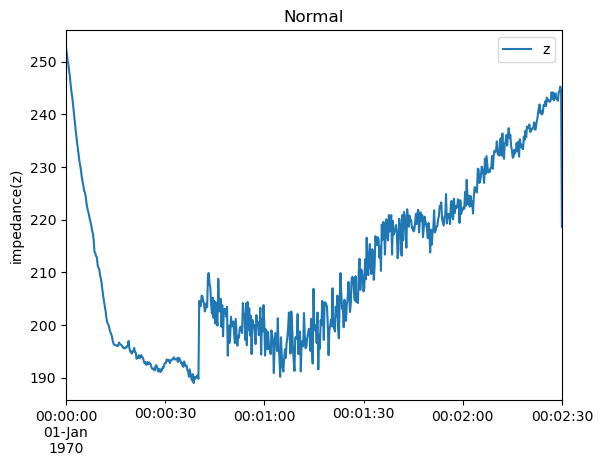

In [10]:
# plotting
df_normal.plot.line();
plt.ylabel('impedance(z)');
plt.title('Normal');

#### Extract impedance and time from sensor log for Sudden High Impedance

In [11]:
# extract impedance data
df_sudden = extract_data(df_list[1][0])
df_sudden

,z
1970-01-01 00:00:00.000,165.3
1970-01-01 00:00:00.240,165.6
1970-01-01 00:00:00.480,165.6
1970-01-01 00:00:00.720,166.3
1970-01-01 00:00:00.960,166.9
...,...
1970-01-01 00:00:30.720,395.9
1970-01-01 00:00:30.960,513.6
1970-01-01 00:00:31.200,809.0
1970-01-01 00:00:31.440,1040.1


#### Evaluate for stationarity
p value is too high, non-stationary.

In [12]:
# evaluate for stationarity
adfuller_test(df_sudden)

Test Statistic            0.111635
p-value                   0.966847
Lags Used                12.000000
Observations Used       120.000000
Critical Vlaue (1%)      -3.486056
Critical Vlaue (5%)      -2.885943
Critical Vlaue (10%)     -2.579785
dtype: float64


#### Plot to visualize time series.

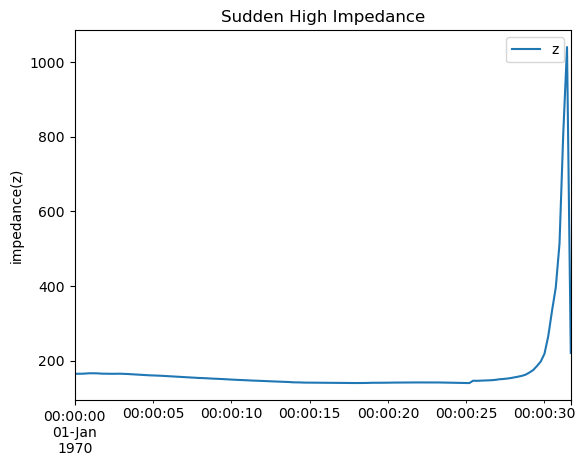

In [13]:
# plotting
df_sudden.plot.line();
plt.ylabel('impedance(z)');
plt.title('Sudden High Impedance');

#### Extract impedance and time from sensor log for Gradual High Impedance

In [14]:
# extract impedance data
df_gradual = extract_data(df_list[2][0])
df_gradual

,z
1970-01-01 00:00:00.000,224.8
1970-01-01 00:00:00.240,223.8
1970-01-01 00:00:00.480,223.5
1970-01-01 00:00:00.720,224.1
1970-01-01 00:00:00.960,224.2
...,...
1970-01-01 00:02:02.160,881.2
1970-01-01 00:02:02.400,940.4
1970-01-01 00:02:02.640,957.6
1970-01-01 00:02:02.880,1004.3


#### Evaluate for stationarity
p value is too high, non-stationary.

In [15]:
# evaluate for stationarity
adfuller_test(df_gradual)

Test Statistic            0.592361
p-value                   0.987426
Lags Used                19.000000
Observations Used       494.000000
Critical Vlaue (1%)      -3.443657
Critical Vlaue (5%)      -2.867408
Critical Vlaue (10%)     -2.569896
dtype: float64


#### Plot to visualize time series.

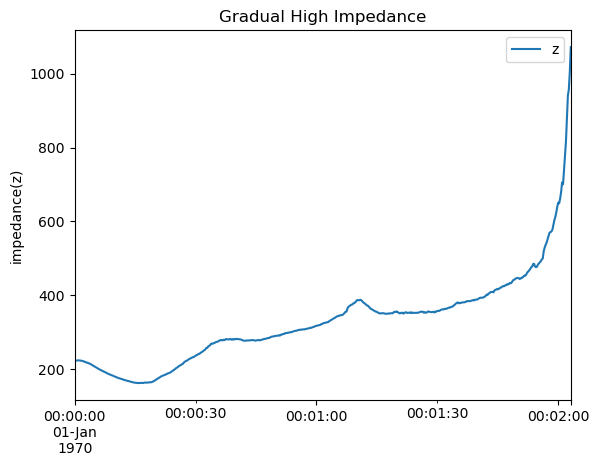

In [16]:
# plotting
df_gradual.plot.line();
plt.ylabel('impedance(z)');
plt.title('Gradual High Impedance');

### <ins>4. Time Series Modeling</ins>
Using Facebook Prophet to forecast if anomaly will occur.
1. No Smoothing
2. Moving Average Smoothing
3. Exponential Smoothing

In [17]:
# change data for Prophet
def change_format(df):
    # new_index = pd.date_range(df.index[0], periods=len(df), freq='1D')
    df['ds'] = df.index
    df = df.rename(columns={"z": "y"})
    df['y'] = np.log10(df['y'])
    # df['y'] = np.log10(df['y'])
    df = df[:-1]

    return df.reset_index(drop=True)

In [18]:
# change data for Prophet
def change_format_ma(df, span):
    # new_index = pd.date_range(df.index[0], periods=len(df), freq='1D')
    df['ds'] = df.index
    df = df.rename(columns={"z": "y"})
    df['y'] = np.log10(df['y'])
    # df['y'] = np.log10(df['y'])
    df['y'] = df['y'].rolling(span).mean()
    df = df[:-1]
    
    return df.reset_index(drop=True)

In [19]:
# change data for Prophet
def change_format_ewa(df, span):
    # new_index = pd.date_range(df.index[0], periods=len(df), freq='1D')
    df['ds'] = df.index
    df = df.rename(columns={"z": "y"})
    df['y'] = np.log10(df['y'])
    # df['y'] = np.log10(df['y'])
    df['y'] = df['y'].ewm(span=span).mean()
    df = df[:-1]
    
    return df.reset_index(drop=True)

In [20]:
# change data for Prophet
def change_format_diff(df):
    # new_index = pd.date_range(df.index[0], periods=len(df), freq='1D')
    df['ds'] = df.index
    df = df.rename(columns={"z": "y"})
    df['y'] = df['y'].diff()
    df = df[:-1]

    return df.reset_index(drop=True)

In [21]:
# change data for Prophet
def change_format_diff_ma(df, span):
    # new_index = pd.date_range(df.index[0], periods=len(df), freq='1D')
    df['ds'] = df.index
    df = df.rename(columns={"z": "y"})
    df['y'] = df['y'].rolling(span).mean()
    df['y'] = df['y'].diff()
    df = df[:-1]

    return df.reset_index(drop=True)

In [22]:
# change data for Prophet
def change_format_diff_ewa(df, span):
    # new_index = pd.date_range(df.index[0], periods=len(df), freq='1D')
    df['ds'] = df.index
    df = df.rename(columns={"z": "y"})
    df['y'] = df['y'].ewm(span=span).mean()
    df['y'] = df['y'].diff()
    df = df[:-1]
    

    return df.reset_index(drop=True)

In [23]:
def expand_yhat(df, scale=1):
    df['range'] = df['yhat_upper'] - df['yhat_lower']
    df['yhat_upper'] = df['yhat'] + df['range']*scale
    df['yhat_lower'] = df['yhat'] - df['range']*scale
    
    return df

#### 4.1. Normal Sensor Measurement

#### 4.1.1 No Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue.

In [24]:
# df_normal_nosmooth = change_format_diff(df_normal)
df_normal_nosmooth = change_format(df_normal)
df_normal_nosmooth

,y,ds
0,2.402777,1970-01-01 00:00:00.000
1,2.401056,1970-01-01 00:00:00.240
2,2.398634,1970-01-01 00:00:00.480
3,2.397245,1970-01-01 00:00:00.720
4,2.394977,1970-01-01 00:00:00.960
...,...,...
620,2.384891,1970-01-01 00:02:28.800
621,2.387923,1970-01-01 00:02:29.040
622,2.388101,1970-01-01 00:02:29.280
623,2.389698,1970-01-01 00:02:29.520


In [25]:
df_original = df_normal.copy()
df_original['ds'] = df_normal.index
df_original = df_original.rename(columns={"z": "y"})
df_original = df_original.reset_index(drop=True)
df_original
# df_normal.plot(y='z')
# df_normal_nosmooth.plot(y='y')
# x = df_normal.copy()
# x['y'] = x['z'].rolling(20).mean()
# x.plot(y='y')
# x['y'] = x['y'].diff()
# x.plot(y='y')
# x['y'] = x['z'].ewm(span=20).mean()
# x.plot(y='y')
# x['y'] = x['y'].diff()
# x.plot(y='y')

,y,ds
0,252.8,1970-01-01 00:00:00.000
1,251.8,1970-01-01 00:00:00.240
2,250.4,1970-01-01 00:00:00.480
3,249.6,1970-01-01 00:00:00.720
4,248.3,1970-01-01 00:00:00.960
...,...,...
621,244.3,1970-01-01 00:02:29.040
622,244.4,1970-01-01 00:02:29.280
623,245.3,1970-01-01 00:02:29.520
624,244.5,1970-01-01 00:02:29.760


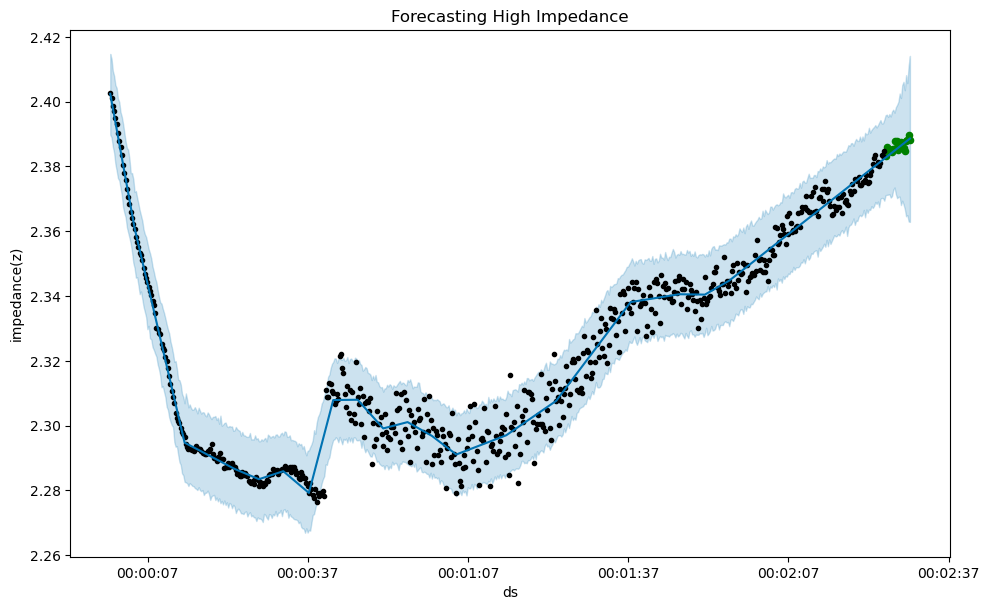

In [26]:
future_timestep = 20
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(df_normal_nosmooth.iloc[:-1*future_timestep])
future = m.make_future_dataframe(periods=future_timestep, freq='240L')
forecast = m.predict(future)
m.plot(forecast);

ax = plt.gca();
df_normal_nosmooth['anomaly'] = 0
df_normal_nosmooth.loc[df_normal_nosmooth['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_normal_nosmooth_predict = df_normal_nosmooth.iloc[-1*future_timestep:]
df_normal_nosmooth_predict[df_normal_nosmooth_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_normal_nosmooth_predict[df_normal_nosmooth_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');


#### 4.1.2 Moving Average Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue.

In [27]:
# df_normal_ma = change_format_diff_ma(df_normal, 20)
df_normal_ma = change_format_ma(df_normal, 20)
# df_normal_ma = df_normal_ma.dropna()
df_normal_ma

,y,ds
0,NaN,1970-01-01 00:00:00.000
1,NaN,1970-01-01 00:00:00.240
2,NaN,1970-01-01 00:00:00.480
3,NaN,1970-01-01 00:00:00.720
4,NaN,1970-01-01 00:00:00.960
...,...,...
620,2.385094,1970-01-01 00:02:28.800
621,2.385443,1970-01-01 00:02:29.040
622,2.385675,1970-01-01 00:02:29.280
623,2.385996,1970-01-01 00:02:29.520


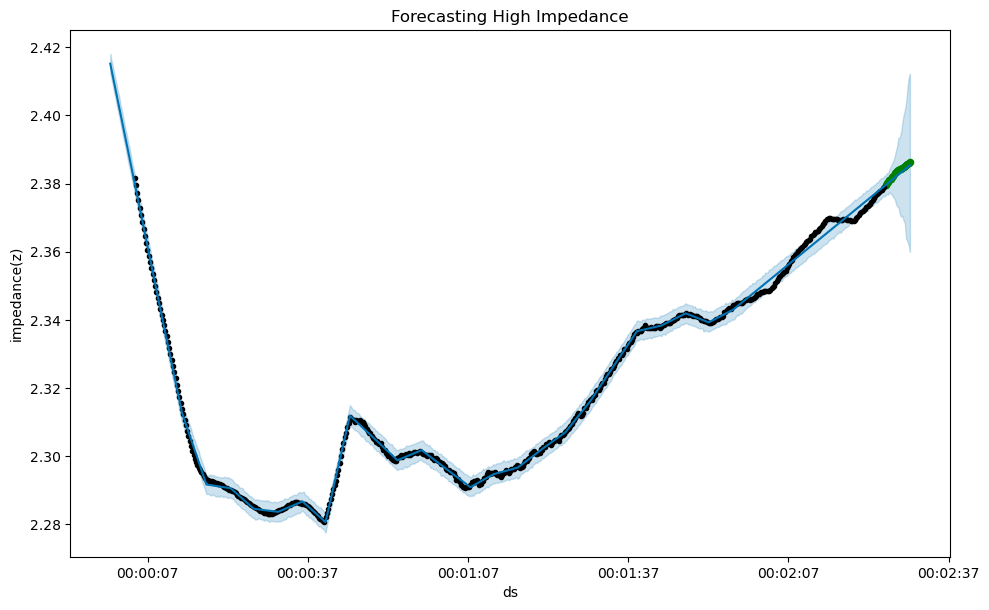

In [28]:
future_timestep = 20
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(df_normal_ma.iloc[:-1*future_timestep])
future = m.make_future_dataframe(periods=future_timestep, freq='240L')
forecast = m.predict(future)
m.plot(forecast);

ax = plt.gca();
df_normal_ma['anomaly'] = 0
df_normal_ma.loc[df_normal_ma['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_normal_ma_predict = df_normal_ma.iloc[-1*future_timestep:]
df_normal_ma_predict[df_normal_ma_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_normal_ma_predict[df_normal_ma_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

#### 4.1.3 Exponential Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue.

In [29]:
df_normal_ewm = change_format_ewa(df_normal, 30)
# df_normal_ewm = change_format_diff_ewa(df_normal, 20)
# df_normal_ma = df_normal_ma.dropna()
df_normal_ewm

,y,ds
0,2.402777,1970-01-01 00:00:00.000
1,2.401888,1970-01-01 00:00:00.240
2,2.400730,1970-01-01 00:00:00.480
3,2.399770,1970-01-01 00:00:00.720
4,2.398679,1970-01-01 00:00:00.960
...,...,...
620,2.382959,1970-01-01 00:02:28.800
621,2.383280,1970-01-01 00:02:29.040
622,2.383591,1970-01-01 00:02:29.280
623,2.383985,1970-01-01 00:02:29.520


In [30]:
future_timestep = 30
start_exam_timestep = 60
df_anomaly = pd.DataFrame()
for i in range(int((df_normal_ewm.shape[0]-start_exam_timestep)/future_timestep)+1):
    data = df_normal_ewm.iloc[:(i+1)*future_timestep+start_exam_timestep]    
    data2 = data.copy()
    data2.loc[:, 'anomaly'] = 0

    if i > 1:
        m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
        m.fit(data.iloc[:-1*future_timestep])
        future = m.make_future_dataframe(periods=future_timestep, freq='240L')
        forecast = m.predict(future)
        forecast = expand_yhat(forecast, 0.6)

        data2.loc[data['y'] > forecast['yhat_upper'], 'anomaly'] = 1
    
    data3 = data2.iloc[-1*future_timestep:].copy()
    if future_timestep*0.5 > data3['anomaly'].sum():
        data3.loc[:, 'anomaly'] = 0
        
    df_anomaly = pd.concat([df_anomaly, data3])


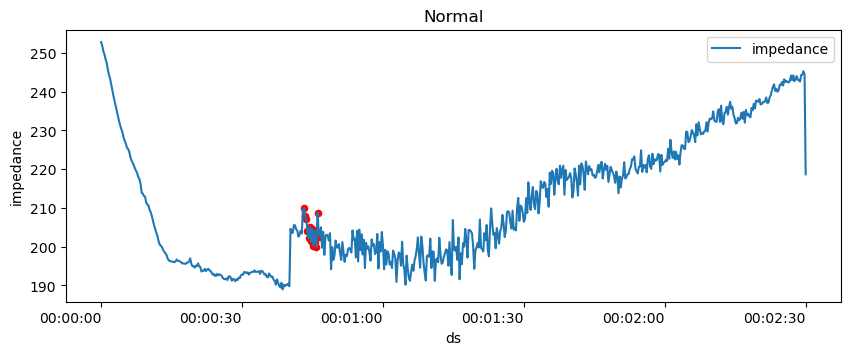

In [31]:
df_out = pd.merge(df_original, df_anomaly, on='ds', how='outer')
df_out = df_out.rename(columns={"y_x": "impedance"})

ax = plt.gca();
df_out.plot(x='ds', y='impedance', ax=ax, figsize=(10, 4));
# df_out[df_out['anomaly'] == 0].plot.scatter(x='ds', y='impedance', ax=ax, color='green');
df_out[df_out['anomaly'] == 1].plot.scatter(x='ds', y='impedance', ax=ax, color='red');
plt.title('Normal');

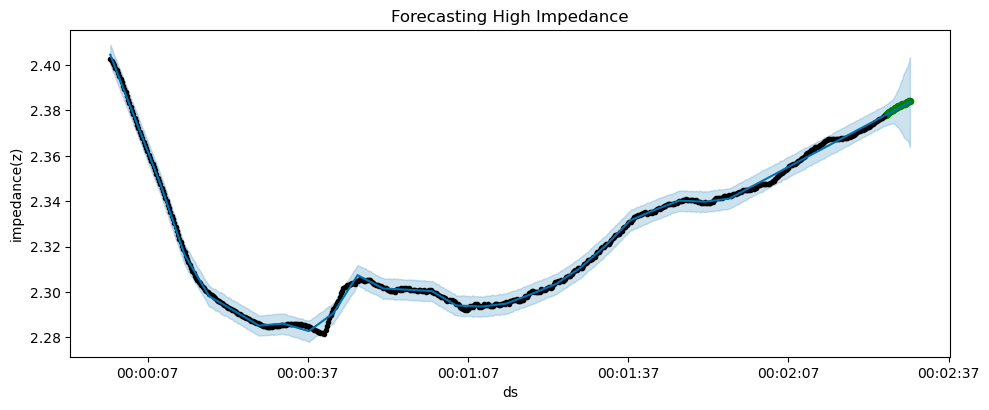

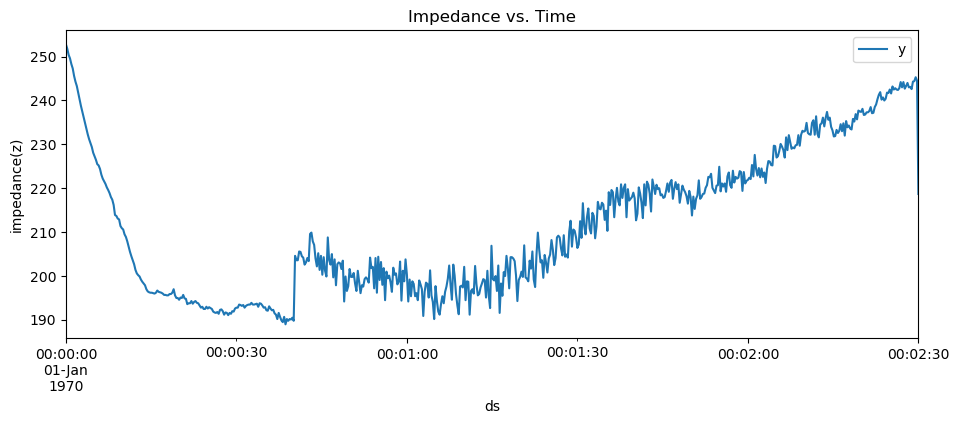

In [32]:
future_timestep = 20
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.95)
m.fit(df_normal_ewm.iloc[:-1*future_timestep])
future = m.make_future_dataframe(periods=future_timestep, freq='240L')
forecast = m.predict(future)
forecast = expand_yhat(forecast)
fig = m.plot(forecast, figsize=(10, 4));

ax = fig.gca();
df_normal_ewm['anomaly'] = 0
df_normal_ewm.loc[df_normal_ewm['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_normal_ewm_predict = df_normal_ewm.iloc[-1*future_timestep:]
df_normal_ewm_predict[df_normal_ewm_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_normal_ewm_predict[df_normal_ewm_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

df_original.plot(x='ds', y='y', figsize=(11, 4));
ax = fig.gca();
plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Impedance vs. Time');

#### 4.2. Sudden High Impedance Sensor Measurement

#### 4.2.1 No Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue. Red dots indicate anomaly detects as measurements are not greater than forcasted upper range.

In [33]:
# df_sudden_nosmooth = change_format_diff(df_sudden)
df_sudden_nosmooth = change_format(df_sudden)
df_sudden_nosmooth

,y,ds
0,2.218273,1970-01-01 00:00:00.000
1,2.219060,1970-01-01 00:00:00.240
2,2.219060,1970-01-01 00:00:00.480
3,2.220892,1970-01-01 00:00:00.720
4,2.222456,1970-01-01 00:00:00.960
...,...,...
127,2.523096,1970-01-01 00:00:30.480
128,2.597586,1970-01-01 00:00:30.720
129,2.710625,1970-01-01 00:00:30.960
130,2.907949,1970-01-01 00:00:31.200


In [34]:
df_original = df_sudden.copy()
df_original['ds'] = df_original.index
df_original = df_original.rename(columns={"z": "y"})
df_original = df_original.reset_index(drop=True)
df_original

,y,ds
0,165.3,1970-01-01 00:00:00.000
1,165.6,1970-01-01 00:00:00.240
2,165.6,1970-01-01 00:00:00.480
3,166.3,1970-01-01 00:00:00.720
4,166.9,1970-01-01 00:00:00.960
...,...,...
128,395.9,1970-01-01 00:00:30.720
129,513.6,1970-01-01 00:00:30.960
130,809.0,1970-01-01 00:00:31.200
131,1040.1,1970-01-01 00:00:31.440


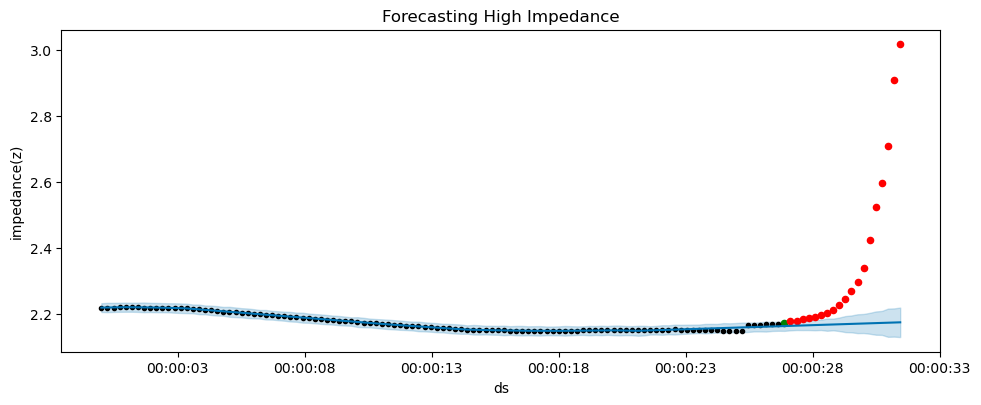

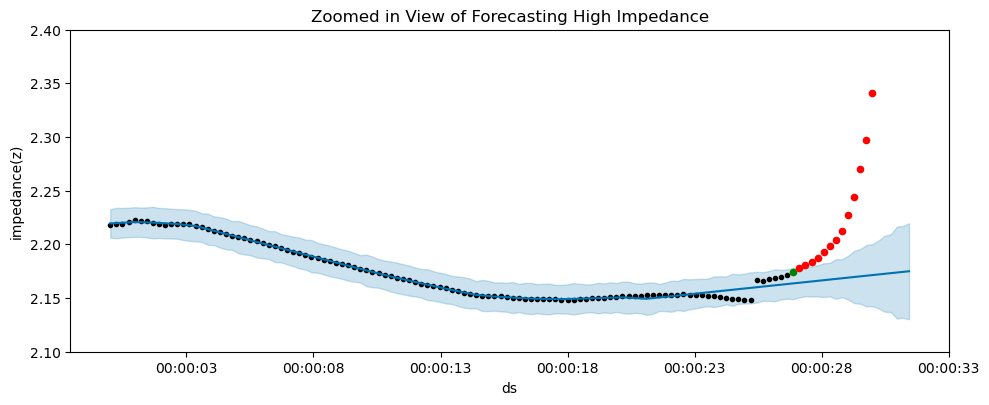

In [35]:
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(df_sudden_nosmooth.iloc[:-20])
future = m.make_future_dataframe(periods=20, freq='240L')
forecast = m.predict(future)
forecast = expand_yhat(forecast)
fig = m.plot(forecast, figsize=(10, 4));

ax = fig.gca();
df_sudden_nosmooth['anomaly'] = 0
df_sudden_nosmooth.loc[df_sudden_nosmooth['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_sudden_nosmooth_predict = df_sudden_nosmooth.iloc[-20:]
df_sudden_nosmooth_predict[df_sudden_nosmooth_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_sudden_nosmooth_predict[df_sudden_nosmooth_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

fig = m.plot(forecast, figsize=(10, 4));
ax = plt.gca();
df_sudden_nosmooth_predict[df_sudden_nosmooth_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green', ylim=(2.1, 2.4));
df_sudden_nosmooth_predict[df_sudden_nosmooth_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red', ylim=(2.1, 2.4));
# ax.set_xlim(left=pd.Timestamp("1970-01-01 00:00:15"))

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Zoomed in View of Forecasting High Impedance');

#### 4.2.2 Moving Average Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue. Red dots indicate anomaly detects as measurements are not greater than forcasted upper range.

In [36]:
df_sudden_ma = change_format_ma(df_sudden, 20)
# df_sudden_ma = change_format_diff_ma(df_sudden, 20)
# df_normal_ma = df_normal_ma.dropna()
df_sudden_ma

,y,ds
0,NaN,1970-01-01 00:00:00.000
1,NaN,1970-01-01 00:00:00.240
2,NaN,1970-01-01 00:00:00.480
3,NaN,1970-01-01 00:00:00.720
4,NaN,1970-01-01 00:00:00.960
...,...,...
127,2.235808,1970-01-01 00:00:30.480
128,2.257307,1970-01-01 00:00:30.720
129,2.284399,1970-01-01 00:00:30.960
130,2.321312,1970-01-01 00:00:31.200


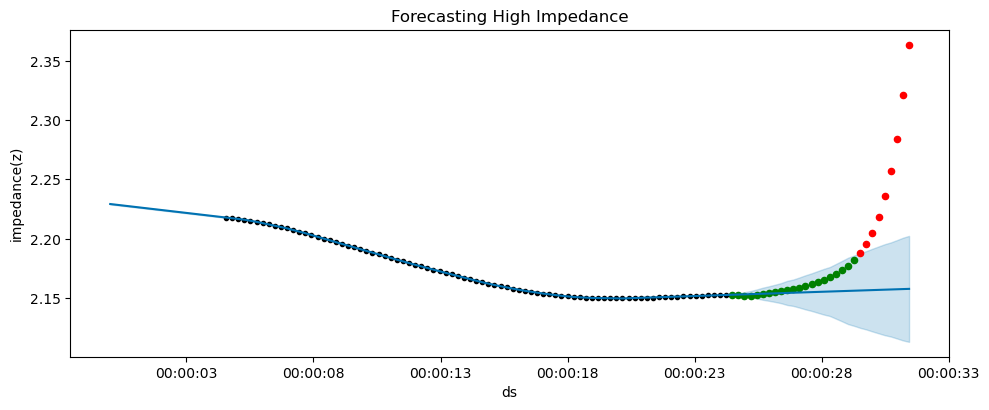

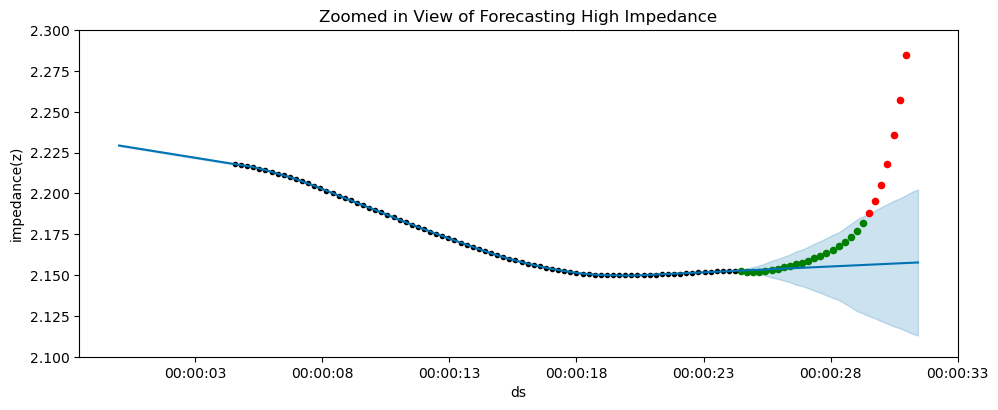

In [37]:
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(df_sudden_ma.iloc[:-30])
future = m.make_future_dataframe(periods=30, freq='240L')
forecast = m.predict(future)
forecast = expand_yhat(forecast)
fig = m.plot(forecast, figsize=(10, 4));

ax = plt.gca();
df_sudden_ma['anomaly'] = 0
df_sudden_ma.loc[df_sudden_ma['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_sudden_ma_predict = df_sudden_ma.iloc[-30:]
df_sudden_ma_predict[df_sudden_ma_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_sudden_ma_predict[df_sudden_ma_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

fig = m.plot(forecast, figsize=(10, 4));
ax = plt.gca();
df_sudden_ma_predict[df_sudden_ma_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_sudden_ma_predict[df_sudden_ma_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red', ylim=(2.1, 2.3));
# ax.set_xlim(left=pd.Timestamp("1970-01-01 00:00:15"))

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Zoomed in View of Forecasting High Impedance');

#### 4.2.3 Exponential Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue. Red dots indicate anomaly detects as measurements are not greater than forcasted upper range.

In [38]:
df_sudden_ewm = change_format_ewa(df_sudden, 20)
# df_sudden_ewm = change_format_diff_ewa(df_sudden, 20)
# df_normal_ma = df_normal_ma.dropna()
df_sudden_ewm

,y,ds
0,2.218273,1970-01-01 00:00:00.000
1,2.218686,1970-01-01 00:00:00.240
2,2.218824,1970-01-01 00:00:00.480
3,2.219421,1970-01-01 00:00:00.720
4,2.220155,1970-01-01 00:00:00.960
...,...,...
127,2.266161,1970-01-01 00:00:30.480
128,2.297725,1970-01-01 00:00:30.720
129,2.337049,1970-01-01 00:00:30.960
130,2.391420,1970-01-01 00:00:31.200


In [39]:
future_timestep = 30
start_exam_timestep = 60
df_anomaly = pd.DataFrame()
for i in range(int((df_sudden_ewm.shape[0]-start_exam_timestep)/future_timestep)+1):
    data = df_sudden_ewm.iloc[:(i+1)*future_timestep+start_exam_timestep]    
    data2 = data.copy()
    data2.loc[:, 'anomaly'] = 0

    if i > 1:
        m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
        m.fit(data.iloc[:-1*future_timestep])
        future = m.make_future_dataframe(periods=future_timestep, freq='240L')
        forecast = m.predict(future)
        forecast = expand_yhat(forecast, 0.6)

        data2.loc[data['y'] > forecast['yhat_upper'], 'anomaly'] = 1
    
    data3 = data2.iloc[-1*future_timestep:].copy()
    if future_timestep*0.5 > data3['anomaly'].sum():
        data3.loc[:, 'anomaly'] = 0
        
    df_anomaly = pd.concat([df_anomaly, data3])


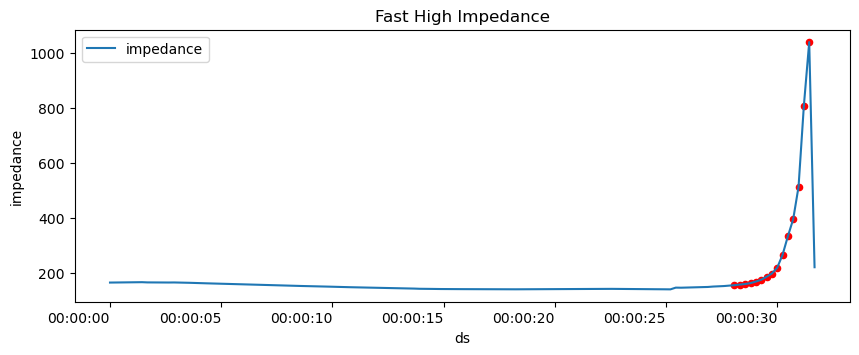

In [40]:
df_out = pd.merge(df_original, df_anomaly, on='ds', how='outer')
df_out = df_out.rename(columns={"y_x": "impedance"})

ax = plt.gca();
df_out.plot(x='ds', y='impedance', ax=ax, figsize=(10, 4));
# df_out[df_out['anomaly'] == 0].plot.scatter(x='ds', y='impedance', ax=ax, color='green');
df_out[df_out['anomaly'] == 1].plot.scatter(x='ds', y='impedance', ax=ax, color='red');
plt.title('Fast High Impedance');

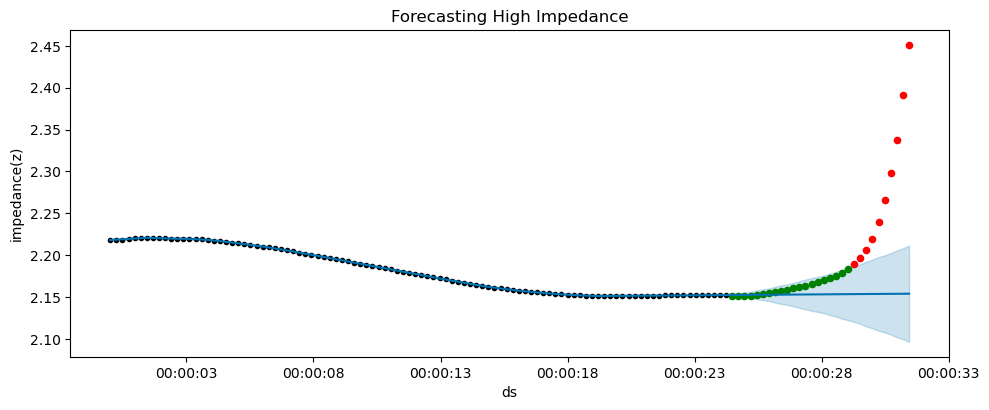

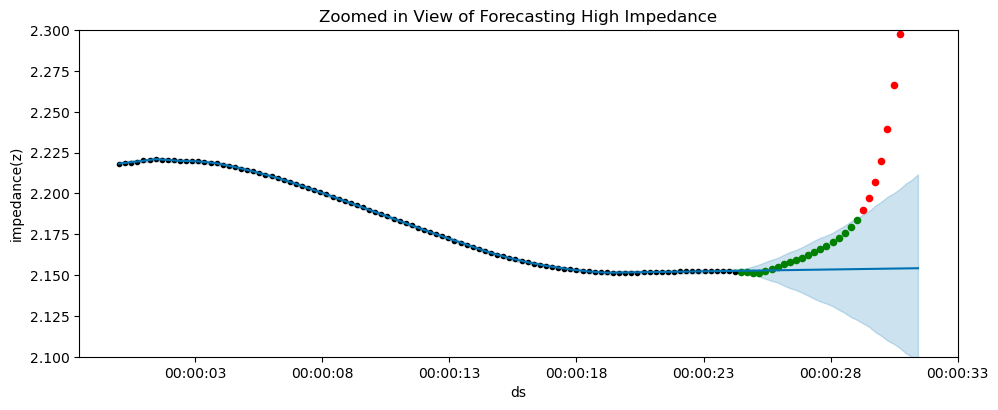

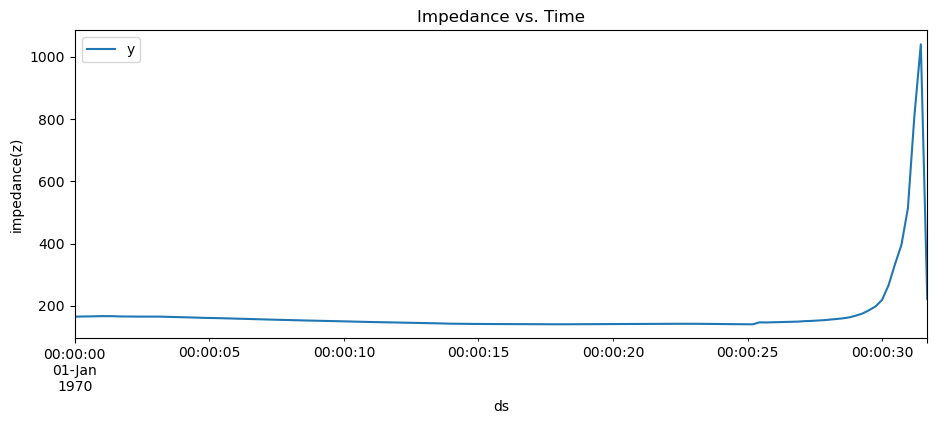

In [41]:
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(df_sudden_ewm.iloc[:-30])
future = m.make_future_dataframe(periods=30, freq='240L')
forecast = m.predict(future)
forecast = expand_yhat(forecast)
fig = m.plot(forecast, figsize=(10, 4));

ax = plt.gca();
df_sudden_ewm['anomaly'] = 0
df_sudden_ewm.loc[df_sudden_ewm['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_sudden_ewm_predict = df_sudden_ewm.iloc[-30:]
df_sudden_ewm_predict[df_sudden_ewm_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_sudden_ewm_predict[df_sudden_ewm_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

fig = m.plot(forecast, figsize=(10, 4));
ax = plt.gca();
df_sudden_ewm_predict[df_sudden_ewm_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_sudden_ewm_predict[df_sudden_ewm_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red', ylim=(2.1, 2.3));
# ax.set_xlim(left=pd.Timestamp("1970-01-01 00:00:15"))

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Zoomed in View of Forecasting High Impedance');

df_original.plot(x='ds', y='y', figsize=(11, 4));
ax = fig.gca();
plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Impedance vs. Time');

In [42]:
df_sudden_ewm[df_sudden_ewm['anomaly']==1].head(1)

,y,ds,anomaly
122,2.189682,1970-01-01 00:00:29.280,1


In [43]:
df_original[df_original['y']>1000].head(1)

,y,ds
131,1040.1,1970-01-01 00:00:31.440


#### 4.3. Gradual High Impedance Sensor Measurement

#### 4.3.1 No Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue. Red dots indicate anomaly detects as measurements are not greater than forcasted upper range.

In [44]:
# df_gradual_nosmooth = change_format_diff(df_gradual)
df_gradual_nosmooth = change_format(df_gradual)
df_gradual_nosmooth

,y,ds
0,2.351796,1970-01-01 00:00:00.000
1,2.349860,1970-01-01 00:00:00.240
2,2.349278,1970-01-01 00:00:00.480
3,2.350442,1970-01-01 00:00:00.720
4,2.350636,1970-01-01 00:00:00.960
...,...,...
508,2.911584,1970-01-01 00:02:01.920
509,2.945074,1970-01-01 00:02:02.160
510,2.973313,1970-01-01 00:02:02.400
511,2.981184,1970-01-01 00:02:02.640


In [45]:
df_original = df_gradual.copy()
df_original['ds'] = df_original.index
df_original = df_original.rename(columns={"z": "y"})
df_original = df_original.reset_index(drop=True)
df_original

,y,ds
0,224.8,1970-01-01 00:00:00.000
1,223.8,1970-01-01 00:00:00.240
2,223.5,1970-01-01 00:00:00.480
3,224.1,1970-01-01 00:00:00.720
4,224.2,1970-01-01 00:00:00.960
...,...,...
509,881.2,1970-01-01 00:02:02.160
510,940.4,1970-01-01 00:02:02.400
511,957.6,1970-01-01 00:02:02.640
512,1004.3,1970-01-01 00:02:02.880


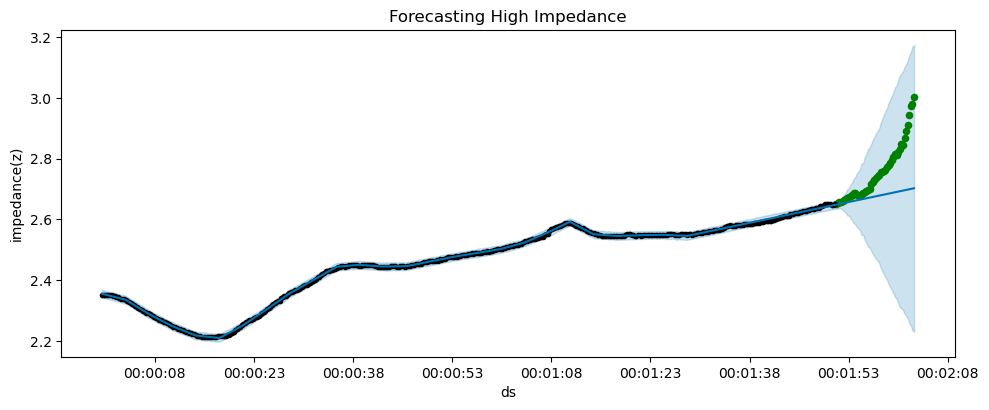

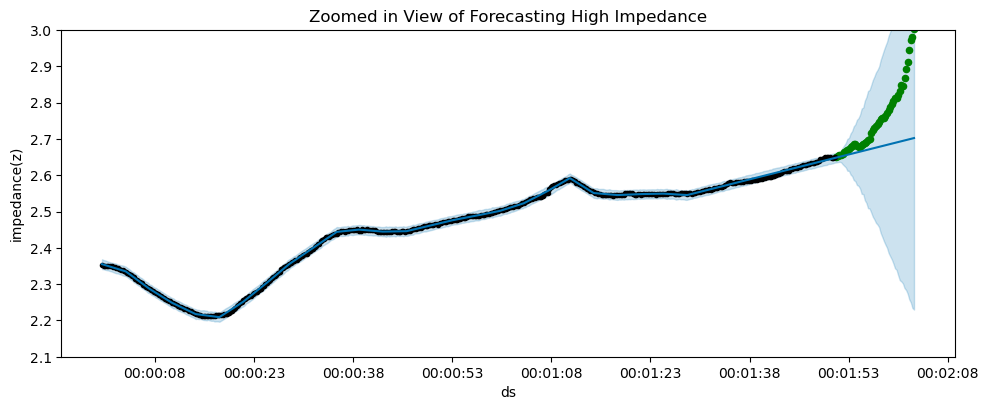

In [46]:
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(df_gradual_nosmooth.iloc[:-50])
future = m.make_future_dataframe(periods=50, freq='240L')
forecast = m.predict(future)
forecast = expand_yhat(forecast)
fig = m.plot(forecast, figsize=(10, 4));

ax = plt.gca();
df_gradual_nosmooth['anomaly'] = 0
df_gradual_nosmooth.loc[df_gradual_nosmooth['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_gradual_nosmooth_predict = df_gradual_nosmooth.iloc[-50:]
df_gradual_nosmooth_predict[df_gradual_nosmooth_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_gradual_nosmooth_predict[df_gradual_nosmooth_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

fig = m.plot(forecast, figsize=(10, 4));
ax = plt.gca();
df_gradual_nosmooth_predict[df_gradual_nosmooth_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_gradual_nosmooth_predict[df_gradual_nosmooth_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red', ylim=(2.1, 3.0));
# ax.set_xlim(left=pd.Timestamp("1970-01-01 00:01:20"))

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Zoomed in View of Forecasting High Impedance');

#### 4.3.2 Moving Average Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue. Red dots indicate anomaly detects as measurements are not greater than forcasted upper range.

In [47]:
df_gradual_ma = change_format_ma(df_gradual, 20)
# df_gradual_ma = change_format_diff_ma(df_gradual, 20)
# df_normal_ma = df_normal_ma.dropna()
df_gradual_ma

,y,ds
0,NaN,1970-01-01 00:00:00.000
1,NaN,1970-01-01 00:00:00.240
2,NaN,1970-01-01 00:00:00.480
3,NaN,1970-01-01 00:00:00.720
4,NaN,1970-01-01 00:00:00.960
...,...,...
508,2.805314,1970-01-01 00:02:01.920
509,2.815495,1970-01-01 00:02:02.160
510,2.826794,1970-01-01 00:02:02.400
511,2.838082,1970-01-01 00:02:02.640


In [48]:
future_timestep = 30
start_exam_timestep = 60
df_anomaly = pd.DataFrame()
for i in range(int((df_gradual_ma.shape[0]-start_exam_timestep)/future_timestep)+1):
    data = df_gradual_ma.iloc[:(i+1)*future_timestep+start_exam_timestep]    
    data2 = data.copy()
    data2.loc[:, 'anomaly'] = 0

    if i > 1:
        m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
        m.fit(data.iloc[:-1*future_timestep])
        future = m.make_future_dataframe(periods=future_timestep, freq='240L')
        forecast = m.predict(future)
        forecast = expand_yhat(forecast, 0.6)

        data2.loc[data['y'] > forecast['yhat_upper'], 'anomaly'] = 1
    
    data3 = data2.iloc[-1*future_timestep:].copy()
    if future_timestep*0.5 > data3['anomaly'].sum():
        data3.loc[:, 'anomaly'] = 0
        
    df_anomaly = pd.concat([df_anomaly, data3])


<AxesSubplot:xlabel='ds', ylabel='impedance'>

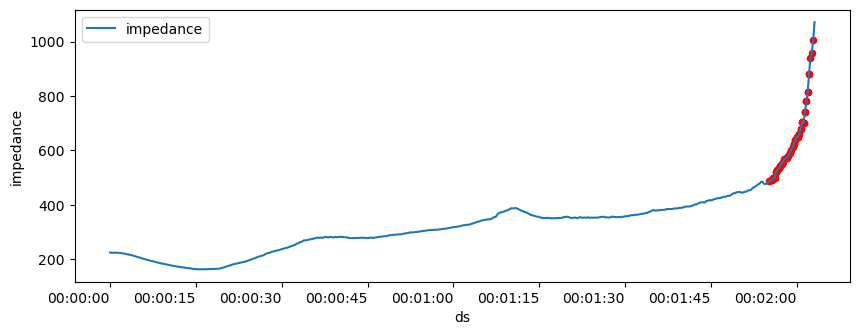

In [49]:
df_out = pd.merge(df_original, df_anomaly, on='ds', how='outer')
df_out = df_out.rename(columns={"y_x": "impedance"})

ax = plt.gca();
fig = df_out.plot(x='ds', y='impedance', ax=ax, figsize=(10, 4));
# df_out[df_out['anomaly'] == 0].plot.scatter(x='ds', y='impedance', ax=ax, color='green')
df_out[df_out['anomaly'] == 1].plot.scatter(x='ds', y='impedance', ax=ax, color='red')

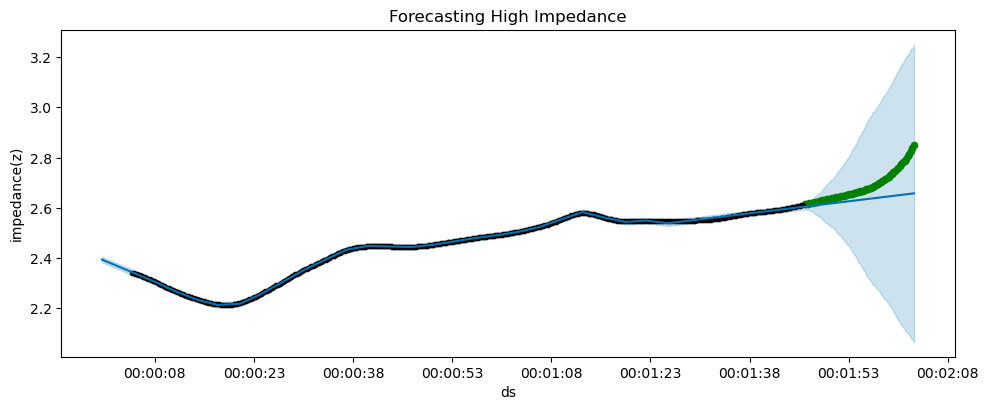

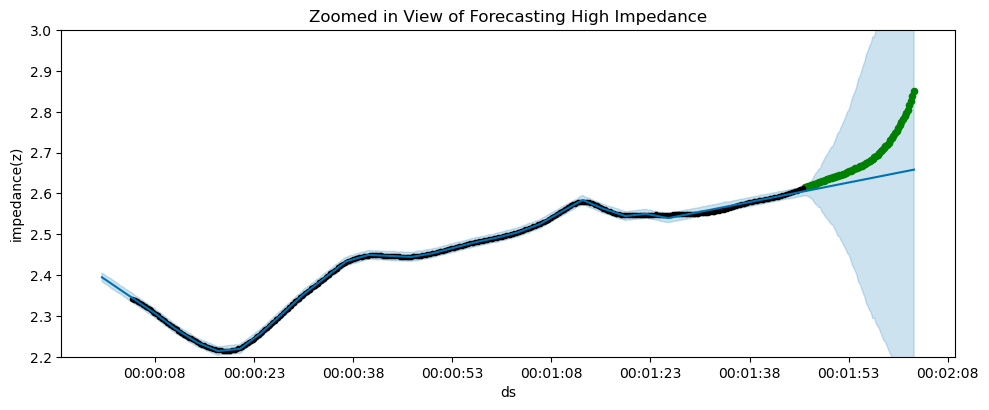

In [50]:
m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(df_gradual_ma.iloc[:-70])
future = m.make_future_dataframe(periods=70, freq='240L')
forecast = m.predict(future)
forecast = expand_yhat(forecast)
fig = m.plot(forecast, figsize=(10, 4));

ax = plt.gca();
df_gradual_ma['anomaly'] = 0
df_gradual_ma.loc[df_gradual_ma['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
df_gradual_ma_predict = df_gradual_ma.iloc[-70:]
df_gradual_ma_predict[df_gradual_ma_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_gradual_ma_predict[df_gradual_ma_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

fig = m.plot(forecast, figsize=(10, 4));
ax = plt.gca();
df_gradual_ma_predict[df_gradual_ma_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
df_gradual_ma_predict[df_gradual_ma_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red', ylim=(2.2, 3.0));
# ax.set_xlim(left=pd.Timestamp("1970-01-01 00:01:30"))

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Zoomed in View of Forecasting High Impedance');


#### 4.3.3 Exponential Smoothing
Green dots indicate no anomaly detected as measurements are less than the forecasted upper range enveloped in blue. Red dots indicate anomaly detects as measurements are not greater than forcasted upper range.

In [51]:
# df_gradual_ewm = change_format_diff_ewa(df_gradual, 20)
df_gradual_ewm = change_format_ewa(df_gradual, 20)
# df_normal_ma = df_normal_ma.dropna()
df_gradual_ewm

,y,ds
0,2.351796,1970-01-01 00:00:00.000
1,2.350780,1970-01-01 00:00:00.240
2,2.350228,1970-01-01 00:00:00.480
3,2.350290,1970-01-01 00:00:00.720
4,2.350373,1970-01-01 00:00:00.960
...,...,...
508,2.813421,1970-01-01 00:02:01.920
509,2.825959,1970-01-01 00:02:02.160
510,2.839993,1970-01-01 00:02:02.400
511,2.853440,1970-01-01 00:02:02.640


In [52]:
future_timestep = 30
start_exam_timestep = 100
df_anomaly = pd.DataFrame()
for i in range(int((df_gradual_ewm.shape[0]-start_exam_timestep)/future_timestep)+1):
    data = df_gradual_ewm.iloc[:(i+1)*future_timestep+start_exam_timestep]    
    data2 = data.copy()
    data2.loc[:, 'anomaly'] = 0

    if i > 1:
        m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
        m.fit(data.iloc[:-1*future_timestep])
        future = m.make_future_dataframe(periods=future_timestep, freq='240L')
        forecast = m.predict(future)
        forecast = expand_yhat(forecast, 0.6)

        data2.loc[data['y'] > forecast['yhat_upper'], 'anomaly'] = 1
    
    # print(data2.iloc[-1*future_timestep:])
    data3 = data2.iloc[-1*future_timestep:].copy()
    if future_timestep*0.5 > data3['anomaly'].sum():
        data3.loc[:, 'anomaly'] = 0
        
    df_anomaly = pd.concat([df_anomaly, data3])


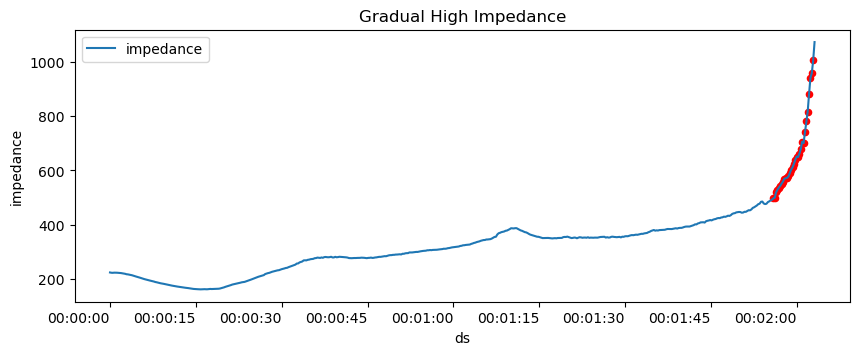

In [53]:
df_out = pd.merge(df_original, df_anomaly, on='ds', how='outer')
df_out = df_out.rename(columns={"y_x": "impedance"})

ax = plt.gca();
df_out.plot(x='ds', y='impedance', ax=ax, figsize=(10, 4));
# df_out[df_out['anomaly'] == 0].plot.scatter(x='ds', y='impedance', ax=ax, color='green');
df_out[df_out['anomaly'] == 1].plot.scatter(x='ds', y='impedance', ax=ax, color='red');
plt.title('Gradual High Impedance');

C:\Users\kay\AppData\Local\Temp\ipykernel_14176\2067432277.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anomaly'] = 0


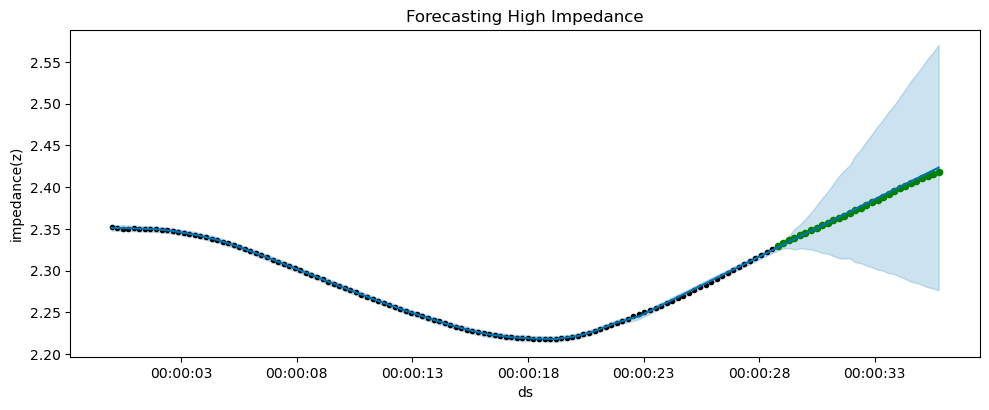

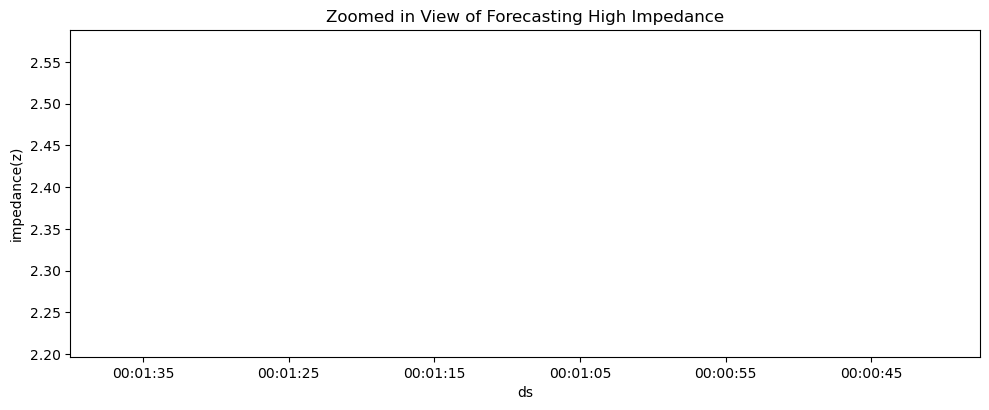

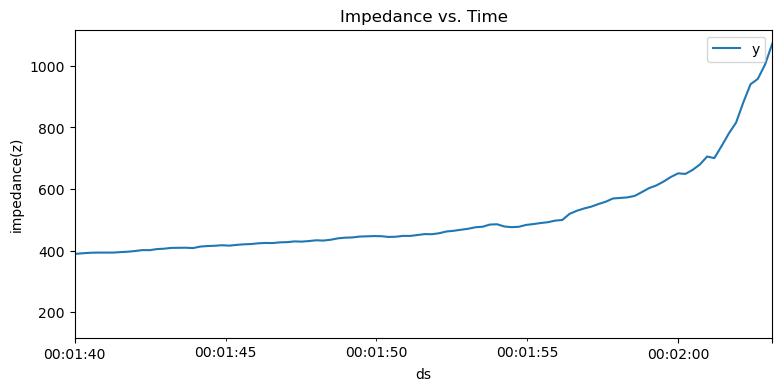

In [54]:
future_timestep = 150
data = df_gradual_ewm.iloc[:future_timestep]

m = fbprophet.Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, interval_width=0.99)
m.fit(data.iloc[:-1*30])
future = m.make_future_dataframe(periods=30, freq='240L')

forecast = m.predict(future)
forecast = expand_yhat(forecast)
fig = m.plot(forecast, figsize=(10, 4));

ax = plt.gca();
data['anomaly'] = 0
data.loc[data['y'] > forecast['yhat_upper'], 'anomaly'] = 1
# df_normal.iloc[-20:].plot.scatter(x='ds', y='anomaly', ax=ax, color='red');
data_predict = data.iloc[-1*30:]
data_predict[data_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
data_predict[data_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Forecasting High Impedance');

fig = m.plot(forecast, figsize=(10, 4));
ax = plt.gca();
data_predict[data_predict['anomaly'] == 0].plot.scatter(x='ds', y='y', ax=ax, color='green');
data_predict[data_predict['anomaly'] == 1].plot.scatter(x='ds', y='y', ax=ax, color='red');
ax.set_xlim(left=pd.Timestamp("1970-01-01 00:01:40"))

plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Zoomed in View of Forecasting High Impedance');

df_original.plot(x='ds', y='y', figsize=(9, 4));
ax2 = plt.gca();
ax2.set_xlim(left=pd.Timestamp("1970-01-01 00:01:40"))
plt.ylabel('time');
plt.ylabel('impedance(z)');
plt.title('Impedance vs. Time');